In [17]:
import os
import glob
import wfdb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler
from functools import partial

from skorch import NeuralNetRegressor
from torch.utils.data import Dataset, DataLoader
from skimage.restoration import denoise_wavelet
from sklearn.model_selection import GridSearchCV

In [58]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

data_directory = "./data/CEBS/m001"
sampling_rate = '10L' # 10ms https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases
target_snr_db = 5

segment_size = '10240L'
segment_size_seconds = int(pd.to_timedelta(segment_size).total_seconds())
segment_size_samples = int(pd.to_timedelta(segment_size).total_seconds() / pd.to_timedelta(sampling_rate).total_seconds())

num_epochs = 10
batch_size = 64
learning_rate = 0.001
weight_decay = 0.01

In [3]:
def signaltonoise_dB(signal_clean, signal_noisy):
    signal_clean_watts = signal_clean ** 2
    signal_clean_avg_watts = np.mean(signal_clean_watts)
    signal_clean_avg_db = 10 * np.log10(signal_clean_avg_watts)

    noise = signal_noisy - signal_clean
    noise_watts = noise ** 2
    noise_avg_watts = np.mean(noise_watts)
    noise_avg_db = 10 * np.log10(noise_avg_watts)

    return signal_clean_avg_db - noise_avg_db

In [4]:
def load_dataset(directory):
    record = wfdb.rdsamp(directory)
    data = record[0]
    metadata = record[1]

    # frequency = metadata['fs']
    column_names = metadata['sig_name']
    # length = metadata['sig_len']

    data = pd.DataFrame(data, columns=column_names)
    data.drop(['I', 'II', 'RESP'], axis=1, inplace=True)

    # frequency_string = str(int(1/frequency*1000000)) + 'U'
    # index = pd.date_range(start='1/1/1970', periods=length, freq=frequency_string)
    # data.set_index(index, inplace=True)
    # data.resample(sampling_rate).mean().SCG
    
    return data

In [5]:
def load_datasets(directory):

    filenames = list(dict.fromkeys([x[:-4] for x in glob.glob(r'./data/CEBS/*[0-9][0-9][0-9].*')]))
    data = pd.concat((load_dataset(filename) for filename in filenames), ignore_index=True)

    frequency = 5000
    length = data.shape[0]
    frequency_string = str(int(1/frequency*1000000)) + 'U'
    index = pd.date_range(start='1/1/1970', periods=length, freq=frequency_string)
    data.set_index(index, inplace=True)

    return data

In [6]:
def add_gaussian(data, target_snr_db):
    data_watts = data ** 2
    data_avg_watts = np.mean(data_watts)
    data_avg_db = 10 * np.log10(data_avg_watts)

    noise_avg_db = data_avg_db - target_snr_db
    noise_avg_watts = 10 ** (noise_avg_db / 10)

    mean_noise = 0
    noise = np.random.normal(mean_noise, np.sqrt(noise_avg_watts), len(data_watts))

    data_noisy = data + noise
    return data_noisy

In [7]:
class SCGData(Dataset):

    def __init__(self, transform=None):

        data = load_datasets('./data/CEBS/')
        data = data.resample(sampling_rate).mean().SCG

        data_noisy = add_gaussian(data, target_snr_db)
        data = pd.DataFrame({'clean': data, 'noise': data_noisy})


        # https://www.geeksforgeeks.org/data-normalization-with-pandas/
        for column in data.columns:
            data[column] = (data[column] - data[column].min()) / (data[column].max() - data[column].min())

        data = data.groupby((data.index - data.index[0]).total_seconds() * 1e3 // (segment_size_samples * 10)).agg(list)
        data = data[data['clean'].apply(lambda x: len(x) == segment_size_samples)]
        data['clean'] = data['clean'].apply(lambda x: np.array(x))
        data['noise'] = data['noise'].apply(lambda x: np.array(x))
        
        self.x_data = data.noise.values
        self.y_data = data.clean.values

        self.transform = transform
        self.n_samples = data.shape[0]

    def __getitem__(self, index):
        sample = self.x_data[index], self.y_data[index]

        if self.transform:
            sample = self.transform(sample)
        
        return sample
    
    def __len__(self):
        return self.n_samples


class ToTensor:
    def __call__(self, sample):
        inputs, targets = sample
        return torch.Tensor(inputs), torch.Tensor(targets)

In [8]:
dataset = SCGData(transform=ToTensor())

In [9]:
def load_data():
    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size
    return torch.utils.data.random_split(dataset, [train_size, test_size])


In [10]:
class DeNoise(nn.Module):
    def __init__(self):
        super(DeNoise, self).__init__()

        # (i-k +2*p)/s+1
        # (i-1)*s+k-2p
        self.encoder = nn.Sequential(
            nn.Conv1d(1, 40, 16, stride=2), # (1024 - 16 +2*0) / 2 + 1 = 505
            nn.BatchNorm1d(40),
            nn.ELU(),
            nn.Conv1d(40, 20, 16, stride=2), # (505 - 16 +2*0) / 2 + 1 = 245
            nn.BatchNorm1d(20),
            nn.ELU(),
            nn.Conv1d(20, 20, 16, stride=2), # (245 - 16 +2*0) / 2 + 1 = 115
            nn.BatchNorm1d(20),
            nn.ELU(),
            nn.Conv1d(20, 20, 16, stride=2), # (115 - 16 +2*0) / 2 + 1 = 50
            nn.BatchNorm1d(20),
            nn.ELU(),
            nn.Conv1d(20, 40, 16, stride=2), # (50 - 16 +2*0) / 2 + 1 = 18
            nn.BatchNorm1d(40),
            nn.ELU(),
            nn.Conv1d(40, 1, 16, stride=1), # (18 - 16 +2*0) / 1 + 1 = 3
            nn.BatchNorm1d(1),
            nn.ELU()
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(1, 1, 16, stride=1), # (3 - 1) * 1 + 16 = 18
            nn.BatchNorm1d(1),
            nn.ELU(),
            nn.ConvTranspose1d(1, 40, 16, stride=2), # (18 - 1) * 2 + 16 = 50
            nn.BatchNorm1d(40),
            nn.ELU(),
            nn.ConvTranspose1d(40, 20, 16, stride=2), # (50 - 1) * 2 + 16 = 114
            nn.BatchNorm1d(20),
            nn.ELU(),
            nn.ConvTranspose1d(20, 20, 16, stride=2), # (114 - 1) * 2 + 16 = 242
            nn.BatchNorm1d(20),
            nn.ELU(),
            nn.ConvTranspose1d(20, 20, 16, stride=2), # (242 - 1) * 2 + 16 = 498
            nn.BatchNorm1d(20),
            nn.ELU(),
            nn.ConvTranspose1d(20, 40, 16, stride=2), # (498 - 1) * 2 + 16 = 1010
            nn.BatchNorm1d(40),
            nn.ELU(),
            nn.ConvTranspose1d(40, 1, 15, stride=1) # (1010 - 1) * 1 + 15 = 1024
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [11]:
class DeNoise2(nn.Module):
    def __init__(self):
        super(DeNoise2, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(1024, 512),
            nn.BatchNorm1d(1),
            nn.ELU(),
            nn.Dropout(1),
            nn.Linear(512, 256),
            nn.BatchNorm1d(1),
            nn.ELU(),
            nn.Dropout(p=0.5),
            nn.Linear(256, 128),
            nn.BatchNorm1d(1),
            nn.ELU(),
            nn.Dropout(p=0.5),
            nn.Linear(128, 64),
            nn.BatchNorm1d(1),
            nn.ELU(),
            nn.Dropout(p=0.5),
            nn.Linear(64, 32),
            nn.BatchNorm1d(1),
            nn.ELU(),
            nn.Dropout(p=0.5),
            nn.Linear(32, 32),
            nn.ELU(),
            nn.Dropout(p=0.5)
        )

        self.decoder = nn.Sequential(
            nn.Linear(32, 32),
            nn.BatchNorm1d(1),
            nn.ELU(),
            nn.Dropout(p=0.5),
            nn.Linear(32, 64),
            nn.BatchNorm1d(1),
            nn.ELU(),
            nn.Dropout(p=0.5),
            nn.Linear(64, 128),
            nn.BatchNorm1d(1),
            nn.ELU(),
            nn.Dropout(p=0.5),
            nn.Linear(128, 256),
            nn.BatchNorm1d(1),
            nn.ELU(),
            nn.Dropout(p=0.5),
            nn.Linear(256, 512),
            nn.BatchNorm1d(1),
            nn.ELU(),
            nn.Dropout(p=0.5),
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1),
            nn.ELU(),
            nn.Dropout(p=0.5),
            nn.Linear(1024, 1024)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [57]:
# NOTE: Try to normalize between -1 and 1 OR use RELU

def train(config, checkpoint_dir=None, data_dir=None):

    model = DeNoise2().to(device)

    criterion = nn.MSELoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=config['lr'], weight_decay=config['wd'])

    if checkpoint_dir:
        model_state, optimizer_state = torch.load(os.path.join(checkpoint_dir, "checkpoint"))
        model.load_state_dict(model_state)
        optimizer.load_state_dict(optimizer_state)

    train_dataset, test_dataset = load_data()
    test_size = int(0.8 * len(train_dataset))
    val_size = len(train_dataset) - test_size
    train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [test_size, val_size])

    train_loader = DataLoader(dataset=train_dataset, batch_size=config['batch_size'], shuffle=True, num_workers=2)
    val_loader = DataLoader(dataset=val_dataset, batch_size=config['batch_size'], shuffle=True, num_workers=2)

    n_total_steps = len(train_loader)
    min_val_loss = np.inf

    for epoch in range(num_epochs):
        train_loss = 0.0
        epoch_steps = 0
        for i, (inputs, lables) in enumerate(train_loader):
            inputs, lables = inputs.view(-1, 1, segment_size_samples), lables.view(-1, 1, segment_size_samples)
            inputs, lables = inputs.to(device), lables.to(device)

            optimizer.zero_grad()
            output = model(inputs)
            loss = criterion(output, lables)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            epoch_steps += 1

            #if (i + 1) % 50 == 0:
            #    print(f'epoch {epoch + 1} / {num_epochs}, step {i + 1} / {n_total_steps}, loss = {loss.item():.10f}')

        val_loss = 0.0
        val_steps = 0
        total = 0
        correct = 0
        for i, (inputs, lables) in enumerate(val_loader):
            inputs, lables = inputs.view(-1, 1, segment_size_samples), lables.view(-1, 1, segment_size_samples)
            inputs, lables = inputs.to(device), lables.to(device)

            output = model(inputs)
            _, predicted = torch.max(output.data, 1)
            total += lables.size(0)
            correct += (predicted == lables).sum().item()

            loss = criterion(output, lables)
            val_loss += loss.item()
            val_steps += 1

        with tune.checkpoint_dir(epoch) as checkpoint_dir:
            path = os.path.join(checkpoint_dir, 'checkpoint')
            torch.save((model.state_dict(), optimizer.state_dict()), path)
        
        tune.report(loss=(val_loss / val_steps), accuracy=correct / total)

        # print(f'epoch {epoch + 1} / {num_epochs}, train loss = {(train_loss / len(train_loader)):.10f}, val loss = {(val_loss / len(val_loader)):.10f}')
        #if min_val_loss > val_loss:
        #    print(f'\tval loss decreased from {min_val_loss:.10f} to {val_loss:.10f}')
        #    min_val_loss = val_loss

        #    torch.save(model.state_dict(), 'model.pth')
    
    #FILE = 'model.pth'
    #torch.save(model.state_dict(), FILE)       

In [ ]:
num_samples = 10
max_num_epochs = 10

config = {
    'lr': tune.loguniform(1e-4, 1e-1),
    'wd': tune.loguniform(1e-3, 1e-1)
    'batch_size': tune.choice([2, 4, 8, 16])
}

scheduler = ASHAScheduler(metric='loss', mode='min', max_t=max_num_epochs, grace_period=1, reduction_factor=2)
reporter = CLIReporter(metric_columns=['loss', 'accuracy', 'training_iteration'])
result = tune.run(
    partial(train, data_dir=None),
    resources_per_trial={'cpu': 4, 'gpu': 1},
    config=config,
    num_samples=num_samples,
    scheduler=scheduler,
    progress_reporter=reporter
)

best_trial = result.get_best_trial('loss', 'min', 'last')
print("Best trial config: {}".format(best_trial.config))
print("Best trial final validation loss: {}".format(best_trial.last_result["loss"]))
print("Best trial final validation accuracy: {}".format(best_trial.last_result["accuracy"]))

best_trained_model =  DeNoise2().to(device)

best_checkpoint_dir = best_trial.checkpoint.value
model_state, optimizer_state = torch.load(os.path.join(best_checkpoint_dir, 'checkpoint'))
best_trained_model.load_state_dict(model_state)

In [55]:
#model = DeNoise2().to(device)
train({'lr': 0.0001, 'batch_size': 16})

#train(num_epochs, model, train_loader, val_loader)

#FILE = 'model.pth'
#torch.save(model.state_dict(), FILE)

epoch 1 / 100, train loss = 0.2901932326, val loss = 0.1245163045
epoch 2 / 100, train loss = 0.0746524585, val loss = 0.0476358604
epoch 3 / 100, train loss = 0.0365900110, val loss = 0.0282361167
epoch 4 / 100, train loss = 0.0234277941, val loss = 0.0192473492
epoch 5 / 100, train loss = 0.0165564372, val loss = 0.0139837606
epoch 6 / 100, train loss = 0.0120951205, val loss = 0.0106769983
epoch 7 / 100, train loss = 0.0093350877, val loss = 0.0083826156
epoch 8 / 100, train loss = 0.0074632213, val loss = 0.0066637834
epoch 9 / 100, train loss = 0.0061931080, val loss = 0.0057905764
epoch 10 / 100, train loss = 0.0051412418, val loss = 0.0048256932
epoch 11 / 100, train loss = 0.0044523672, val loss = 0.0041705857
epoch 12 / 100, train loss = 0.0038157380, val loss = 0.0037070245
epoch 13 / 100, train loss = 0.0033466598, val loss = 0.0032023727
epoch 14 / 100, train loss = 0.0029655233, val loss = 0.0029449958
epoch 15 / 100, train loss = 0.0026433517, val loss = 0.0024870283
epoc

In [52]:
net = NeuralNetRegressor(DeNoise().to(device), max_epochs=100, lr=0.001, verbose=1)

noise = dataset.x_data.reshape(-1, 1)
clean = dataset.y_data.reshape(-1, 1)

print(type(noise[0][0][0]))
print(type(clean[0][0][0]))

params = {
    'lr': [0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3],
    'max_epochs': list(range(500, 5500, 500))
}
gs = GridSearchCV(net, params, refit=False, scoring='r2', verbose=1, cv=10)
# gs.fit(noise, clean)

<class 'numpy.float64'>
<class 'numpy.float64'>


48.11108946800232
45.46997904777527


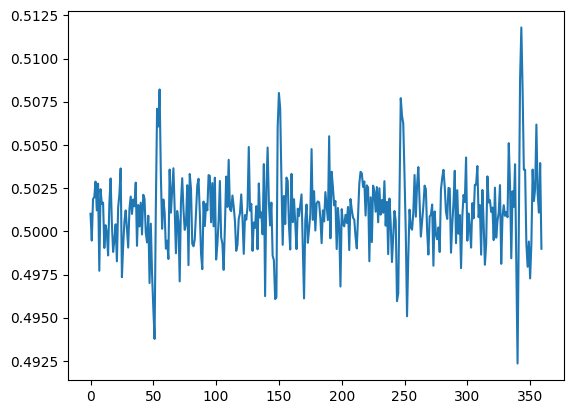

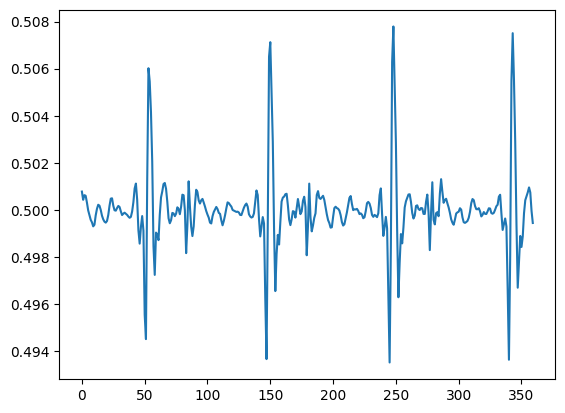

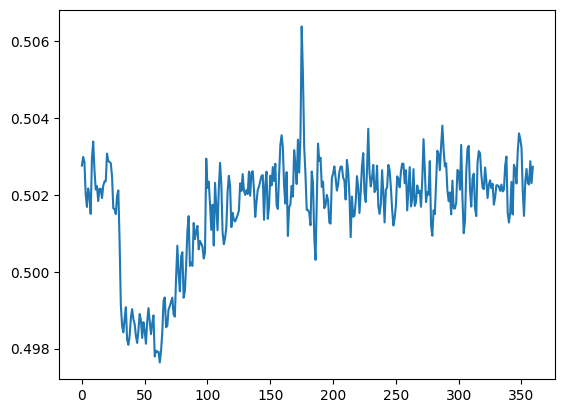

In [56]:
#model = DeNoise().to(device)
model.load_state_dict(torch.load('model.pth'))
model.eval()

with torch.no_grad():

    #denoised = denoise_wavelet(data.noise, method='BayesShrink', mode='soft', wavelet_levels=1, wavelet='sym8', rescale_sigma='True')
    
    noise = dataset[100][0].view(1, 1, segment_size_samples).to(device)
    clean = dataset[100][1].view(1, 1, segment_size_samples).to(device)

    predicted = model(noise).to('cpu').view(segment_size_samples).numpy()
    clean = clean.to('cpu').view(segment_size_samples).numpy()
    noise = noise.to('cpu').view(segment_size_samples).numpy()

    print(signaltonoise_dB(clean, noise))
    print(signaltonoise_dB(clean, predicted))

    time = 360
    plt.plot(range(time), noise[:time])
    plt.show()
    plt.plot(range(time), clean[:time])
    plt.show()
    plt.plot(range(time), predicted[:time])
    plt.show()